In [1]:
import pandas as pd

from scipy.stats import f_oneway,levene,shapiro, kruskal
import pingouin as pg

from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
path_cz_pataka = "czech_pataka.csv"
path_cz_spa = "czech_spa.csv"
path_sp_pataka = "spanish_pataka.csv"
path_sp_spa = "spanish_spa.csv"

In [3]:
class Reader:
    def __init__(self, path):
        """
        Initialize the Reader object with the specified file path.

        Parameters:
        - path (str): The path to the CSV file containing the data.
        """
        self.path = path
        self.data = self.read_file()
        self.remove_empty_columns()
        self.data_filled = self.fill_with_mean()
        self.data_preprocessed = self.perform_data_specific_preprocessing()
        self.add_status_column()
        self.remove_string_columns()

    def remove_empty_columns(self):
        """
        Remove columns with more than 50% missing values.

        """
        empty_rate = self.data.isnull().sum() / self.data.shape[0] * 100
        columns_to_drop = empty_rate[empty_rate > 50].keys()
        self.data = self.data.drop(columns=columns_to_drop)

    def read_file(self):
        """
        Read data from a CSV file into a pandas DataFrame.

        Returns:
        - DataFrame: The loaded data as a pandas DataFrame.
        """
        return pd.read_csv(self.path)

    def fill_with_mean(self):
        """
        Fill missing numeric values with the mean of the respective column.

        Returns:
        - DataFrame: The data with missing values filled with column means.
        """
        return self.data.fillna(self.data.mean(numeric_only=True))

    def aggregate_samples(self):
        """
        Aggregate samples by participant ID and compute the mean.

        Returns:
        - DataFrame: The aggregated data with means computed for each participant.
        """
        return self.data_filled.groupby('participant_id').mean(numeric_only= True).reset_index()

    def remove_second_attempt(self):
        """
        Remove rows with 'repetition' column value equal to 'b'.

        Returns:
        - DataFrame: The data with rows where 'repetition' is 'b' removed.
        """
        return self.data_filled[self.data_filled['repetition'] != 'b'].copy()

    def perform_data_specific_preprocessing(self):
        """
        Perform data-specific preprocessing based on the file path.

        Returns:
        - DataFrame: The preprocessed data.
        """
        if 'czech_pataka' in self.path:
            return self.remove_second_attempt()
        elif 'spa' in self.path:
            return self.aggregate_samples()
        else:
            return self.data_filled

    def add_status_column(self):
        """
        The 'status' column is assigned 'HC' if 'C' is in the participant ID, otherwise 'PD'.
        """
        self.data_preprocessed['status'] = self.data_preprocessed['participant_id'].apply(lambda x: 'HC' if 'C' in x else 'PD')

    def remove_string_columns(self):
        """
        Remove specific string columns based on the file path.
        """
        if 'czech_pataka' in self.path:
            columns_to_remove = ['filename', 'repetition', 'participant_id']
            self.data_preprocessed = self.data_preprocessed.drop(columns=columns_to_remove) 
        else:
            self.data_preprocessed = self.data_preprocessed.drop(columns='participant_id') 

In [4]:
#Instantiate reader objects
cz_pataka_reader = Reader(path_cz_pataka)
cz_spa_reader = Reader(path_cz_spa)
sp_pataka_reader = Reader(path_sp_pataka)
sp_spa_reader = Reader(path_sp_spa)

In [5]:
# Extracting preprocessed data 
cz_pataka = cz_pataka_reader.data_preprocessed
cz_spa = cz_spa_reader.data_preprocessed
sp_pataka= sp_pataka_reader.data_preprocessed 
sp_spa = sp_spa_reader.data_preprocessed 

In [6]:
cz_pataka.head()

,average_time_between_vocalizations,cycle_to_cycle_variability,diadochokinetic_rate,early_relative_pace_stability,late_relative_pace_stability,pace_stability,resonant_frequency_attenuation,std_time_between_vocalizations,syllable_lengths_mean,syllable_lengths_sd,...,pitch_percentile_1,pitch_percentile_99,pitch_percentile_1_99_range,pitch_percentile_20,pitch_percentile_80,pitch_percentile_20_80_range,pitch_linear_regression_offset,pitch_linear_regression_slope,pitch_linear_regression_mse,status
1,0.050286,0.012235,6.277245,186.328125,188.671875,63.584344,0.475023,0.007785,0.108889,0.010546,...,81.331660,115.062132,33.730472,88.032832,101.019007,12.986175,104.888567,-0.129823,28.124026,PD
2,0.050759,0.013474,5.542508,92.045455,108.238636,76.362875,0.582083,0.009916,0.128814,0.010383,...,110.643350,166.057606,55.414256,141.457073,155.558061,14.100988,147.422709,0.002093,94.582959,PD
3,0.042947,0.023784,6.351792,102.925532,104.521277,49.852658,0.628837,0.009784,0.118154,0.023653,...,114.929011,142.989805,28.060794,126.093922,134.624168,8.530246,138.149398,-0.120695,15.193928,PD
6,0.056552,0.044351,6.704545,182.142857,184.285714,385.976102,1.017593,0.046621,0.092203,0.015956,...,105.901558,153.431623,47.530065,124.718780,143.938259,19.219479,130.351300,0.046813,120.638700,HC
12,0.039314,0.014118,7.294833,135.576923,162.980769,111.235497,0.395652,0.009633,0.099111,0.010546,...,118.185037,159.854257,41.669219,138.972962,150.656564,11.683603,149.216415,-0.035758,72.361628,PD


In [7]:
cz_spa.head()

,detrended_fluctuation_analysis,spectral_contrast_mean,spectral_contrast_sd,spectral_flatness_mean,spectral_flatness_sd,spectral_rolloff_mean,spectral_rolloff_sd,tonnetz_fifth_x_mean,tonnetz_fifth_x_sd,tonnetz_fifth_y_mean,...,pitch_percentile_1,pitch_percentile_99,pitch_percentile_1_99_range,pitch_percentile_20,pitch_percentile_80,pitch_percentile_20_80_range,pitch_linear_regression_offset,pitch_linear_regression_slope,pitch_linear_regression_mse,status
0,0.299692,24.989471,5.074512,0.000422,0.000332,1232.730263,93.323418,-0.275389,0.140581,-0.074672,...,99.483410,105.041482,5.558071,100.923670,103.871640,2.947970,101.607560,0.032007,2.301533,HC
1,0.046325,28.125122,5.495117,0.000240,0.000528,1141.629464,176.776673,-0.005754,0.100593,-0.131166,...,114.693500,124.715453,10.021953,117.894347,121.720089,3.825742,118.912042,0.022863,4.913960,HC
2,0.107404,27.122793,6.764706,0.000700,0.000411,1321.595982,34.807456,-0.037470,0.161647,0.257062,...,136.540324,142.373577,5.833253,137.742184,141.151360,3.409176,139.778329,-0.020548,2.922922,HC
3,0.031541,26.796303,5.367014,0.000323,0.000167,1347.377232,158.216544,0.079426,0.130501,-0.190828,...,181.695354,204.616930,22.921577,184.895827,188.177820,3.281993,188.985752,-0.043977,16.837498,HC
4,0.048381,25.341648,6.365405,0.000123,0.000081,932.366071,66.537119,0.075730,0.038875,0.403558,...,122.037849,131.898128,9.860279,127.770935,129.845153,2.074219,127.650282,0.009527,2.740420,HC


In [8]:
sp_spa.head()

,detrended_fluctuation_analysis,spectral_contrast_mean,spectral_contrast_sd,spectral_flatness_mean,spectral_flatness_sd,spectral_rolloff_mean,spectral_rolloff_sd,tonnetz_fifth_x_mean,tonnetz_fifth_x_sd,tonnetz_fifth_y_mean,...,pitch_percentile_1,pitch_percentile_99,pitch_percentile_1_99_range,pitch_percentile_20,pitch_percentile_80,pitch_percentile_20_80_range,pitch_linear_regression_offset,pitch_linear_regression_slope,pitch_linear_regression_mse,status
0,0.048824,21.842929,4.780769,0.003414,0.001837,1897.509657,279.451829,0.021423,0.110102,-0.065132,...,92.394716,97.549030,5.154314,93.415386,95.655534,2.240148,94.936368,-0.019957,2.015066,PD
1,0.030530,22.613530,5.440254,0.005727,0.002000,2763.307267,156.996823,-0.061017,0.284849,-0.039469,...,204.966724,214.705877,9.739153,207.455893,211.339950,3.884056,208.069904,0.084165,4.557776,PD
2,0.023505,19.800739,4.535411,0.015232,0.008110,3914.339158,335.903978,-0.005286,0.165985,-0.007295,...,133.798932,258.135331,124.336399,183.094986,232.655875,49.560889,209.764795,-0.138173,1146.079601,PD
3,0.029010,25.295731,6.011520,0.000386,0.000121,1528.980655,198.514243,-0.387065,0.111094,-0.034471,...,144.670106,149.857146,5.187040,146.507332,148.432409,1.925077,147.074887,0.003491,1.304331,PD
4,0.019000,25.269169,6.411048,0.002154,0.001376,2417.447917,335.582013,0.007061,0.196167,-0.010311,...,132.760626,241.620888,108.860262,155.391854,184.739094,29.347239,195.667458,-0.699670,249.875571,PD


In [9]:
sp_pataka.head()

,average_time_between_vocalizations,cycle_to_cycle_variability,diadochokinetic_rate,early_relative_pace_stability,late_relative_pace_stability,pace_stability,resonant_frequency_attenuation,std_time_between_vocalizations,syllable_lengths_mean,syllable_lengths_sd,...,pitch_percentile_1,pitch_percentile_99,pitch_percentile_1_99_range,pitch_percentile_20,pitch_percentile_80,pitch_percentile_20_80_range,pitch_linear_regression_offset,pitch_linear_regression_slope,pitch_linear_regression_mse,status
0,0.067429,0.105846,4.601227,106.611196,123.415666,132.225978,0.776220,0.028480,0.154667,0.058033,...,86.041623,129.959478,43.917855,93.192355,127.906878,34.714523,110.281661,-0.056694,231.745100,PD
1,0.128640,0.199333,4.213938,106.611196,123.415666,132.225978,0.404038,0.195566,0.120000,0.049861,...,181.067337,253.708237,72.640900,199.057340,247.550722,48.493382,228.203941,-0.032585,527.382335,PD
2,0.164000,0.160000,2.931596,106.611196,123.415666,132.225978,0.992755,0.134996,0.195556,0.028995,...,77.943088,261.215998,183.272910,90.219380,240.210796,149.991415,149.859912,0.283360,3754.582015,PD
3,0.033000,0.029867,6.692913,106.611196,123.415666,132.225978,0.916420,0.010536,0.115765,0.055025,...,66.097188,142.776870,76.679682,109.996667,132.920321,22.923654,125.657540,-0.047819,230.754134,PD
4,0.052000,0.036870,6.053269,79.233871,96.774194,61.288996,0.751281,0.017436,0.115840,0.027258,...,109.246239,216.082748,106.836509,171.579552,210.187156,38.607604,222.328714,-0.528904,508.821953,PD


# Question 1


In [10]:
def assess_normality(dataset, significance_level=0.05):
    """

    This function performs the Shapiro-Wilk test for normality on each feature in the dataset, grouped 'status'.
    Features are classified as normally distributed or not based on the p-value of the Shapiro-Wilk test.
    
    Parameters:
    - dataset (DataFrame): The dataset containing the features to be tested for normality.
    - significance_level (float, optional): The significance level for the Shapiro-Wilk test. Features with p-values greater than or equal to this level are considered normally distributed. Default is 0.05.

    Returns:
    - normally_distributed_features (list): A list of features deemed normally distributed based on the Shapiro-Wilk test.
    - not_normally_distributed_features (list): A list of features deemed not normally distributed based on the Shapiro-Wilk test.
    """
    normally_distributed_features = []
    not_normally_distributed_features = []
    grouped_dataset = dataset.groupby('status')
    columns_to_test = [col for col in dataset.columns if col != 'status']

    for feature in columns_to_test:
        is_normal = all(shapiro(data[feature])[1] >= significance_level for _, data in grouped_dataset)
        if is_normal:
            normally_distributed_features.append(feature)
        else:
            not_normally_distributed_features.append(feature)

    print(f"Total normally distributed features: {len(normally_distributed_features)}")
    print(f"Total not normally distributed features: {len(not_normally_distributed_features)}")
    
    return normally_distributed_features, not_normally_distributed_features


In [11]:

sp_pataka_features = assess_normality(sp_pataka)

Total normally distributed features: 30
Total not normally distributed features: 65


In [12]:

sp_spa_features = assess_normality(sp_spa)

Total normally distributed features: 29
Total not normally distributed features: 74


In [13]:

cz_pataka_features = assess_normality(cz_pataka)

Total normally distributed features: 29
Total not normally distributed features: 66


In [14]:

cz_spa_features = assess_normality(cz_spa)

Total normally distributed features: 21
Total not normally distributed features: 82


In [15]:

sp_pataka_not_normal = sp_pataka[['status'] + sp_pataka_features[1]].copy()
sp_spa_not_normal = sp_spa[['status'] + sp_spa_features[1]].copy()
cz_pataka_not_normal = cz_pataka[['status'] + cz_pataka_features[1]].copy()
cz_spa_not_normal= cz_spa[['status'] + cz_spa_features[1]].copy()

In [16]:

sp_pataka_normal = sp_pataka[['status'] + sp_pataka_features[0]].copy()
sp_spa_normal = sp_spa[['status'] + sp_spa_features[0]].copy()
cz_pataka_normal = cz_pataka[['status'] + cz_pataka_features[0]].copy()
cz_spa_normal= cz_spa[['status'] + cz_spa_features[0]].copy()

In [17]:
def compute_anova(dataset, significance_level=0.05):
    """
    Compute one-way ANOVA for each feature in the dataset.

    Parameters:
    - dataset (DataFrame): The input dataset containing features and the 'status' column.
    - significance_level (float, optional): The significance level for the ANOVA test. Default is 0.05.

    Returns:
    - list: A list of significant features based on the ANOVA test.
    """

    significant_features = []
    grouped_dataset = dataset.groupby('status')

    columns_to_test = [col for col in dataset.columns if col != 'status']

    for feature in columns_to_test:
        f_statistic, p_value = f_oneway(grouped_dataset.get_group('PD')[feature], grouped_dataset.get_group('HC')[feature])
        
        if p_value < significance_level:
            significant_features.append(feature)


    print(f"Total significant features: {len(significant_features)}")

    return significant_features


In [18]:

sp_pataka_significant_features_normal = compute_anova(sp_pataka_normal)
sp_spa_significant_features_normal = compute_anova(sp_spa_normal)
cz_pataka_significant_features_normal = compute_anova(cz_pataka_normal)
cz_spa_significant_features_normal = compute_anova(cz_spa_normal)

Total significant features: 12
Total significant features: 9
Total significant features: 5
Total significant features: 3


In [23]:


def compute_kruskal_wallis(dataset, significance_level=0.05):
    """
    Compute the Kruskal-Wallis H test for each feature in the dataset.

    Parameters:
    - dataset (DataFrame): The input dataset containing features and the 'status' column.
    - significance_level (float, optional): The significance level for the Kruskal-Wallis H test. Default is 0.05.

    Returns:
    - list: A list of significant features based on the Kruskal-Wallis H test.
    """

    significant_features = []
    grouped_dataset = dataset.groupby('status')

    columns_to_test = [col for col in dataset.columns if col != 'status']

    for feature in columns_to_test:
        h_statistic, p_value = kruskal(grouped_dataset.get_group('PD')[feature], grouped_dataset.get_group('HC')[feature])
        
        if p_value < significance_level:
            significant_features.append(feature)

    print(f"Total significant features: {len(significant_features)}")

    return significant_features


In [24]:

sp_pataka_significant_features_not_normal = compute_anova(sp_pataka_not_normal)
sp_spa_significant_features_not_normal= compute_anova(sp_spa_not_normal)
cz_pataka_significant_features_not_normal= compute_anova(cz_pataka_not_normal)
cz_spa_significant_features_not_normal= compute_anova(cz_spa_not_normal)

Total significant features: 24
Total significant features: 26
Total significant features: 10
Total significant features: 6


In [25]:

sp_pataka_significant = sp_pataka[['status'] + sp_pataka_significant_features_not_normal + sp_pataka_significant_features_normal].copy()
sp_spa_significant = sp_spa[['status'] + sp_spa_significant_features_not_normal + sp_spa_significant_features_normal].copy()
cz_pataka_significant = cz_pataka[['status'] + cz_pataka_significant_features_not_normal + cz_pataka_significant_features_normal].copy()
cz_spa_significant= cz_spa[['status'] + cz_spa_significant_features_not_normal + cz_spa_significant_features_normal ].copy()

In [26]:
def perform_feature_selection(data, standardization):
    """
    Perform feature selection using Recursive Feature Elimination with Cross-Validation (RFECV).

    Parameters:
    - data (DataFrame): The input dataset containing features and the 'status' column.
    - standardization (bool): Whether to perform standardization on the features.

    Returns:
    - list: A list of tuples containing the ranking of features and their corresponding names,
            sorted by their importance.
    """
    features = data.drop(['status'], axis=1)
    labels = data['status'] 

    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    if standardization:
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        features = pd.DataFrame(features_scaled, columns=features.columns)

    estimator = SVR(kernel="linear")
    selector = RFECV(estimator, step=1, cv=5)

    selector = selector.fit(features, labels_encoded)

    return list(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), features.columns)))


In [184]:
# Performing feature selection
sp_pataka_relevant_features = perform_feature_selection(sp_pataka_significant, False)
cz_pataka_relevant_features= perform_feature_selection(cz_pataka_significant, False)
cz_spa_relevant_features= perform_feature_selection(cz_spa_significant, False)
sp_spa_relevant_features = perform_feature_selection(sp_spa_significant, True)

In [ ]:
for feature in sp_pataka_relevant_features:
    print(feature)

(1, 'f1_frequency_mean')
(1, 'f2_frequency_mean')
(1, 'loudness_mean')
(1, 'loudness_sd')
(1, 'pitch_min')
(1, 'pitch_percentile_20_80_range')
(1, 'pitch_q3_q1_range')
(1, 'syllable_lengths_mean')
(1, 'utterance_durations_sd')
(2, 'diadochokinetic_rate')
(3, 'alpha_ratio_mean')
(4, 'pause_durations_mean')
(5, 'std_time_between_vocalizations')
(6, 'hnr_sd')
(7, 'cycle_to_cycle_variability')
(8, 'alpha_ratio_sd')
(9, 'average_time_between_vocalizations')
(10, 'utterance_durations_mean')
(11, 'syllable_lengths_sd')
(12, 'h1_h2_harmonic_difference_sd')
(13, 'late_relative_pace_stability')
(14, 'signal_to_noise_ratio')
(15, 'pitch_coefficient_of_variation')
(16, 'average_mfccs_3')
(17, 'average_mfccs_4')
(18, 'f2_relative_energy_sd')
(19, 'average_mfccs_2')
(20, 'f2_relative_energy_mean')
(21, 'pitch_q2_q1_range')
(22, 'pitch_percentile_1')
(23, 'f1_frequency_sd')
(24, 'spectral_slope_500_1500_mean')
(25, 'pause_durations_sd')
(26, 'rate_loudness_peaks')
(27, 'f1_relative_energy_sd')
(28, '

In [ ]:
#Select which features will be used for classification
sp_pataka_selected = list([item[1] for item in sp_pataka_relevant_features if item[0]<= 4])
sp_spa_selected = list([item[1] for item in sp_spa_relevant_features if item[0]<= 6])
cz_pataka_selected = list([item[1] for item in cz_pataka_relevant_features if item[0]<= 3]) 
cz_spa_selected = list([item[1] for item in cz_spa_relevant_features if item[0]<= 1])

In [ ]:
sp_pataka_best= sp_pataka[['status'] + sp_pataka_selected].copy()
sp_spa_best = sp_spa[['status'] + sp_spa_selected].copy()
cz_pataka_best = cz_pataka[['status'] + cz_pataka_selected].copy()
cz_spa_best= cz_spa[['status'] + cz_spa_selected ].copy()

In [ ]:
def classify(data, gamma_value, random):
    """
    Train and evaluate a Support Vector Machine (SVM) classifier using radial basis function (RBF) kernel on the given data,
    and evaluates its performance using accuracy score on a test set.

    Parameters:
    - data (DataFrame): The input dataset containing features and the 'status' column.
    - gamma_value (float): The value of the gamma parameter for the RBF kernel.

    Returns:
    None
    """
    features = data.drop(['status'], axis=1)
    labels = data['status'] 
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state = random)


    svm_classifier = SVC(kernel='rbf', C=1.0, gamma=gamma_value)

    svm_classifier.fit(features_train, labels_train)

    predictions = svm_classifier.predict(features_test)

    accuracy = accuracy_score(labels_test, predictions)
    return round(accuracy*100)


In [115]:
from sklearn.model_selection import cross_val_score

def classify_with_cross_validation(data, gamma_value, cv=10):
    """
    Train and evaluate a Support Vector Machine (SVM) classifier using radial basis function (RBF) kernel on the given data,
    and evaluates its performance using cross-validation.

    Parameters:
    - data (DataFrame): The input dataset containing features and the 'status' column.
    - gamma_value (float): The value of the gamma parameter for the RBF kernel.
    - cv (int, optional): The number of folds for cross-validation. Default is 5.

    Returns:
    - numpy array: Array of cross-validation scores.
    """
    features = data.drop(['status'], axis=1)
    labels = data['status'] 

    svm_classifier = SVC(kernel='rbf', C=1.0, gamma=gamma_value)

    scores = cross_val_score(svm_classifier, features, labels, cv=cv)
    return scores


In [ ]:
# Perform Classification using the best features

sp_pataka_score = classify(sp_pataka_best, 0.2,310)
sp_pataka_features_str = ', '.join(sp_pataka_selected)
print(f"{sp_pataka_score}% accuracy using the following features: {sp_pataka_features_str}")


In [164]:

sp_spa_score = classify(sp_spa_best, 0.1, 73)
sp_spa_features_str = ', '.join(sp_spa_selected)
print(f"{sp_spa_score}% accuracy using the following features: {sp_spa_features_str }")


95% accuracy using the following features: apq3_shimmer, apq5_shimmer, hnr_mean, dda_shimmer, signal_to_noise_ratio, f2_relative_energy_mean, spectral_contrast_mean, f1_relative_energy_sd


In [174]:
cz_pataka_score = classify(cz_pataka_best, 0.2, 100) #118
cz_pataka_features_str = ', '.join(cz_pataka_selected)
print(f"{cz_pataka_score}% Accuracy using the following features: {cz_pataka_features_str}")



90% Accuracy using the following features: cycle_to_cycle_variability, local_jitter, loudness_sd, pause_durations_sd, rate_loudness_peaks, std_time_between_vocalizations, syllable_lengths_mean, utterance_durations_sd, ppq5_jitter, average_time_between_vocalizations


In [166]:

cz_spa_score = classify(cz_spa_best, 0.1, 40)
cz_spa_features_str = ', '.join(cz_spa_selected)
print(f"{cz_spa_score}% accuracy using the following features: {cz_spa_features_str}")


94% accuracy using the following features: average_mfccs_3, spectral_slope_0_500_sd, tonnetz_fifth_x_sd


# Question 2

In [ ]:
def compute_anova_between(sp_dataset, cz_dataset):
    # Initialize a list to store the results
    effect_size = []
    
    # Drop 'status' column from both datasets
    sp_dataset = sp_dataset.drop(columns=['status'])
    cz_dataset = cz_dataset.drop(columns=['status'])
    
    
    # Iterate over each speech feature column
    for feature in sp_dataset.columns[:-1]:
    # Perform ANOVA test for the current feature
        aov = pg.anova(dv=feature, between='language', data=pd.concat([sp_dataset, cz_dataset], axis=0), detailed=True)
        eta_squared = aov['np2'][0]
        effect_size.append((feature, eta_squared))
   
        
        

    effect_size.sort(key=lambda x: x[1], reverse=True)
    #print(f"Total significant features: {len(effect)}")

    # Return the list of significant features
    return effect_size

# Example usage:
# significant_features = compute_anova_between(sp_dataset, cz_dataset)


In [ ]:
test1 = compute_anova_between(sp_pataka, cz_pataka)

In [ ]:
for item in test1:
        if item[1] >= 0.14:
                print(item)

In [ ]:
test2 = compute_anova_between(sp_spa, cz_spa)

In [ ]:
for item in test2:
        if item[1] >= 0.14:
            print(item)

In [ ]:
import pandas as pd
from scipy.stats import f_oneway
from statistics import mean

# Load datasets
dataset1 = sp_spa
dataset2 = cz_spa

# Assuming the columns are already matched, if not, you might need to perform some matching operation here

# List to store results
anova_results = []

# Iterate over matched columns
for col_name in dataset1.columns[:-1]:
    # Run ANOVA test
    statistic, p_value = f_oneway(dataset1[col_name], dataset2[col_name])
    
    # Calculate SS_between
    mean1 = mean(dataset1[col_name])
    mean2 = mean(dataset2[col_name])
    grand_mean = (mean1 + mean2) / 2
    ss_between = len(dataset1[col_name]) * (mean1 - grand_mean)**2 + len(dataset2[col_name]) * (mean2 - grand_mean)**2
    
    # Calculate SS_total
    total_mean = mean(dataset1[col_name].append(dataset2[col_name]))
    ss_total = sum((x - total_mean) ** 2 for x in dataset1[col_name].append(dataset2[col_name]))
    
    # Calculate eta squared
    eta_squared = ss_between / ss_total
    
    # Store results
    anova_results.append({'Column': col_name, 'P-value': p_value, 'Eta Squared': eta_squared})

# Convert results to DataFrame for better visualization
anova_results_df = pd.DataFrame(anova_results)

# Sort DataFrame based on Eta Squared column in descending order
anova_results_df = anova_results_df.sort_values(by='Eta Squared', ascending=False)

print(anova_results_df)


# Question 3

In [218]:
sp_participants_path='spanish_demographics.csv'
cz_participants_path = 'czech_demographics.csv'

In [219]:
class Participant_reader:
    """Class for reading participant data from a CSV file and performing preprocessing tasks."""

    def __init__(self, path):
        """
        Initialize the Participant_reader object.

        Parameters:
        - path (str): The path to the CSV file containing participant data.
        """
        self.path = path
        self.data = self.read_file()
        self.filter_dataset()
        self.add_status_column()

    def read_file(self):
        """
        Read the CSV file and return the DataFrame containing the data.

        Returns:
        - pandas.DataFrame: DataFrame containing the participant data.
        """
        return pd.read_csv(self.path)
    
    def filter_dataset(self):
        """
        Filter the dataset to retain only specified columns.

        Columns preserved: 'participant_id', 'age', 'sex'
        """
        columns_to_preserve=['participant_id', 'age', 'sex']
        self.data= self.data[columns_to_preserve].copy()
      
    
    def add_status_column(self):
        """
        Add a 'status' column to the dataset based on participant IDs.
        """
        self.data['status'] = self.data['participant_id'].apply(lambda x: 'HC' if 'C' in x else 'PD')


In [220]:
sp_reader = Participant_reader(sp_participants_path)
cz_reader = Participant_reader(cz_participants_path)

In [221]:
sp_participants= sp_reader.data
cz_participants= cz_reader.data

In [222]:
cz_participants

,participant_id,age,sex,status
0,PN03_3R,66,M,PD
1,PN04_3R,65,M,PD
2,PN05_3R,62,M,PD
3,PN08_3R,67,F,PD
4,PN15_3R,64,M,PD
...,...,...,...,...
95,HC420,66,F,HC
96,HC421,74,M,HC
97,HC422,66,M,HC
98,HC423,66,F,HC


In [358]:
def calc_mean(dataset):
    """
    Calculate the mean grouped by status.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.

    Returns:
    - pandas.DataFrame: DataFrame containing the mean of age grouped by 'status'.
    """
    return dataset.groupby(['status']).mean(numeric_only = True)

def calc_median(dataset):
    """
    Calculate the median grouped by status.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.

    Returns:
    - pandas.DataFrame: DataFrame containing the median of age grouped by 'status'.
    """
    return dataset.groupby(['status']).median(numeric_only = True)



def calc_sd(dataset):
    """
    Calculate the standard deviation grouped by status.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.

    Returns:
    - pandas.DataFrame: DataFrame containing the standard deviation grouped by 'status'.
    """
    sd = dataset.groupby(['status']).std(numeric_only = True)
    return sd.reset_index()


def calc_cv(dataset):
    """
    Calculate the coefficient of variation grouped by status.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.

    Returns:
    - pandas.Series: Series containing the coefficient of variation grouped by 'status'.
    """
    return dataset.groupby(['status']).std(numeric_only = True) / dataset.groupby(['status']).mean(numeric_only = True) 


def find_max(dataset):
    """
    Find the maximum value of age grouped by status.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.

    Returns:
    - pandas.DataFrame: DataFrame containing the maximum value of age grouped by 'status'.
    """
    return dataset.groupby(['status']).max(numeric_only = True)


def find_min(dataset):
    """
    Find the minimum value of age grouped by status.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.

    Returns:
    - pandas.DataFrame: DataFrame containing the minimum value of  age grouped by 'status'.
    """
    return dataset.groupby(['status']).min(numeric_only = True)


def calc_range(dataset_max, dataset_min):
    """
    Calculate the range of ages between maximum and minimum values for each group.

    Parameters:
    - dataset_max (pandas.DataFrame): DataFrame containing maximum values of age grouped by 'status'.
    - dataset_min (pandas.DataFrame): DataFrame containing minimum values of age grouped by 'status'.

    Returns:
    - tuple: A tuple containing the range of ages for 'HC' (Healthy Control) and 'PD' (Parkinson's Disease) groups.
    """
    control_range = dataset_max.loc['HC', 'age'] - dataset_min.loc['HC', 'age']
    parkinson_range = dataset_max.loc['PD', 'age'] - dataset_min.loc['PD', 'age']
    return control_range, parkinson_range


def quantiles(dataset):
    """
    Calculate the quartiles grouped by status.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.

    Returns:
    - pandas.DataFrame: DataFrame containing the quartiles  grouped by 'status'.
    """
    return dataset.groupby(['status']).quantile([0.25, 0.75], numeric_only = True)


def calc_iqr(dataset):
    """
    Calculate the interquartile range (IQR) of ages for each group.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing quartiles of ages grouped by 'status'.

    Returns:
    - tuple: A tuple containing the IQR of ages for 'HC' (Healthy Control) and 'PD' (Parkinson's Disease) groups.
    """
    hc_iqr = dataset.loc['HC', 0.75] - dataset.loc['HC', 0.25] 
    pd_iqr = dataset.loc['PD', 0.75] - dataset.loc['PD', 0.25] 
    return hc_iqr.values[0], pd_iqr.values[0]


def calc_gender_frequency(dataset):
    """
    Calculate the frequency of gender within each group.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.

    Returns:
    - pandas.Series: Series containing the frequency of each gender within 'HC' and 'PD' groups.
    """
    return dataset.groupby(['status'])['sex'].value_counts()   


def make_boxplot(dataset, language):
    """
    Create a boxplot of ages for 'HC' and 'PD' groups.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.
    - language (str): Language of the dataset used for the plot title.

    Returns:
    - None
    """
    hc_data = dataset[dataset['status'] == 'HC']
    pd_data = dataset[dataset['status'] == 'PD']
    plt.figure(figsize=(8, 6))
    plt.boxplot([hc_data['age'], pd_data['age']], labels=['HC', 'PD'])
    plt.title(f'Boxplot of Age for HC and PD Groups ({language})')
    plt.xlabel('Group')
    plt.ylabel('Age')
    plt.grid(True)
    plt.show()

    
def make_barchart(dataset, language):
    """
    Create a bar chart showing the frequency of gender within 'HC' and 'PD' groups.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.
    - language (str): Language of the dataset used for the plot title.

    Returns:
    - None
    """
    dataset.plot(kind='bar', color=['blue', 'green'])
    plt.title(f'Frequency of Gender by Group ({language})')
    plt.xlabel('Group and Gender')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--')
    plt.show()


def make_kernel_density_plot(dataset):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=dataset[dataset['status'] == 'HC']['age'], fill=True, color='blue', label='Healthy Control')
    sns.kdeplot(data=dataset[dataset['status'] == 'PD']['age'], fill=True, color='red', label='Parkinson\'s Disease')
    plt.title('Kernel Density Plot of Age by Group')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [335]:
print("Means of the Czech dataset:")
print(calc_mean(cz_participants))

Means of the Czech dataset:
          age
status       
HC      61.64
PD      63.42


In [336]:
print("Means of the Spanish dataset:")
print(calc_mean(sp_participants))

Means of the Spanish dataset:
          age
status       
HC      60.98
PD      61.02


In [337]:
print("Medians of the Czech dataset:")
print(calc_median(cz_participants))

Medians of the Czech dataset:
         age
status      
HC      65.0
PD      62.5


In [338]:
print("Median of the Spanish dataset:")
print(calc_median(sp_participants))

Median of the Spanish dataset:
         age
status      
HC      62.0
PD      60.5


In [306]:
print('Standard deviation of the Czech dataset:')
print(calc_sd(cz_participants))

Standard deviation of the Czech dataset:
  status        age
0     HC  11.248147
1     PD   9.547069


In [307]:
print('Standard deviation of the Spanish dataset:')

print(calc_sd(sp_participants))

Standard deviation of the Spanish dataset:
  status       age
0     HC  9.464197
1     PD  9.442609


In [308]:
print('Coefficient of variation of the Czech dataset:')
print(calc_cv(cz_participants))

Coefficient of variation of the Czech dataset:
             age
status          
HC      0.182481
PD      0.150537


In [309]:
print('Coefficient of variation of the Spanish dataset:')
print(calc_cv(sp_participants))

Coefficient of variation of the Spanish dataset:
             age
status          
HC      0.155202
PD      0.154746


In [310]:
print('Oldest participants in the Czech dataset:')
cz_max= find_max(cz_participants)
print(cz_max)

Oldest participants in the Czech dataset:
        age
status     
HC       79
PD       82


In [311]:
print('Oldest participants in the Spanish dataset:')
sp_max= find_max(sp_participants)
print(sp_max)

Oldest participants in the Spanish dataset:
        age
status     
HC       86
PD       81


In [312]:
print('Youngest participants in the Czech dataset:')
cz_min= find_min(cz_participants)
print(cz_min)

Youngest participants in the Czech dataset:
        age
status     
HC       40
PD       41


In [313]:
print('Youngest participants in the Spanish dataset:')
sp_min= find_min(sp_participants)
print(sp_min)

Youngest participants in the Spanish dataset:
        age
status     
HC       31
PD       33


In [326]:
cz_ranges = calc_range(cz_max, cz_min)
print(f"The range of the Czech control group is {cz_ranges[0]}.\nThe range of the Czech parkinson's group is {cz_ranges[1]}.")

The range of the Czech control group is 39.
The range of the czech parkinson's group is 41.


In [330]:
sp_ranges = calc_range(sp_max, sp_min)
print(f"The range of the Spanish control group is {sp_ranges[0]}.\nThe range of the Spanish parkinson's group is {sp_ranges[1]}.")

The range of the Spanish control group is 55.
The range of the Spanish parkinson's group is 48.


In [316]:
print('Czech quantiles:')
cz_quantiles= quantiles(cz_participants)
print(cz_quantiles)

Czech quantiles:
               age
status            
HC     0.25  54.25
       0.75  70.75
PD     0.25  58.00
       0.75  68.75


In [317]:
print('Spanish quantiles:')
sp_quantiles= quantiles(sp_participants)
print(sp_quantiles)

Spanish quantiles:
               age
status            
HC     0.25  55.25
       0.75  66.50
PD     0.25  55.00
       0.75  68.00


In [318]:
cz_iqr = calc_iqr(cz_quantiles)
print(f"The interquartile range of the Czech control group is {cz_iqr[0]}.\nThe interquartile range of the Czech parkinson's group is {cz_iqr[1]}.")


The interquartile range of the czech control group is 16.5.
The interquartile range of the czech parkinson's group is 10.75.


In [329]:
sp_iqr = calc_iqr(sp_quantiles)
print(f"The interquartile range of the Spanish control group is {sp_iqr[0]}.\nThe interquartile range of the Spanish parkinson's group is {sp_iqr[1]}.")


The interquartile range of the Spanish control group is 11.25.
The interquartile range of the Spanish parkinson's group is 13.0.


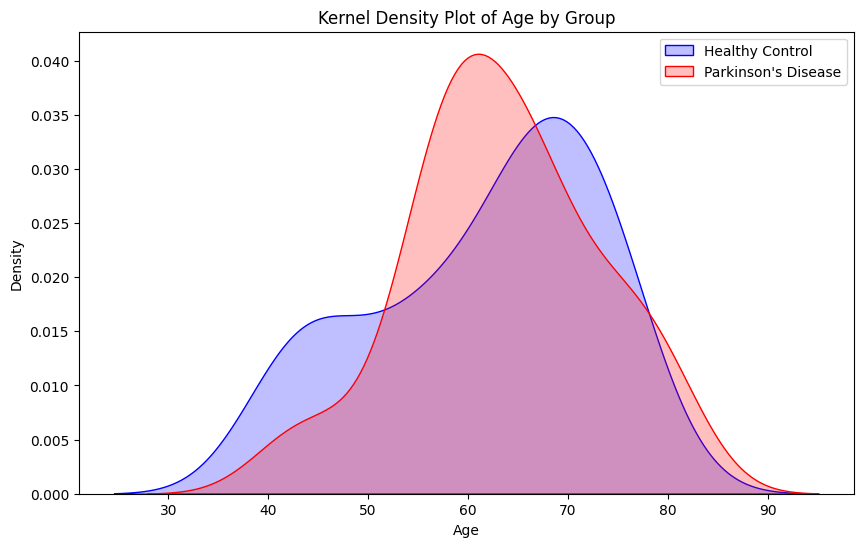

In [359]:
make_kernel_density_plot(cz_participants)

In [360]:
cz_pd_participants = cz_participants[cz_participants['status'] == 'PD']
statistic, p_value = shapiro(cz_pd_participants['age'])


alpha = 0.05
if p_value > alpha:
        print(f"Given a p-value of {p_value}, we do not reject the null hypothesis. The data is normally distributed.")
else:
        print(f"Given a p-value of {p_value}, we reject the null hypothesis. The data is not normally distributed.")


Given a p-value of 0.5056062936782837, we do not reject the null hypothesis. The data is normally distributed.


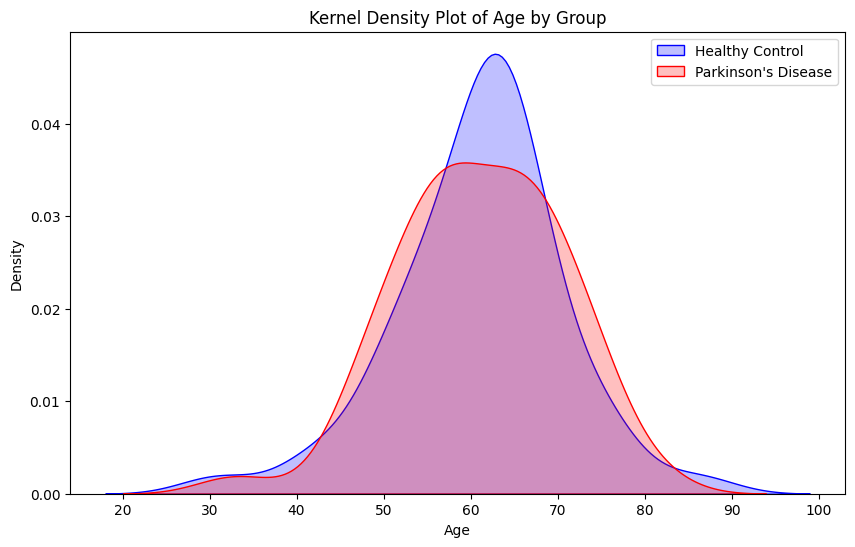

In [361]:
make_kernel_density_plot(sp_participants)

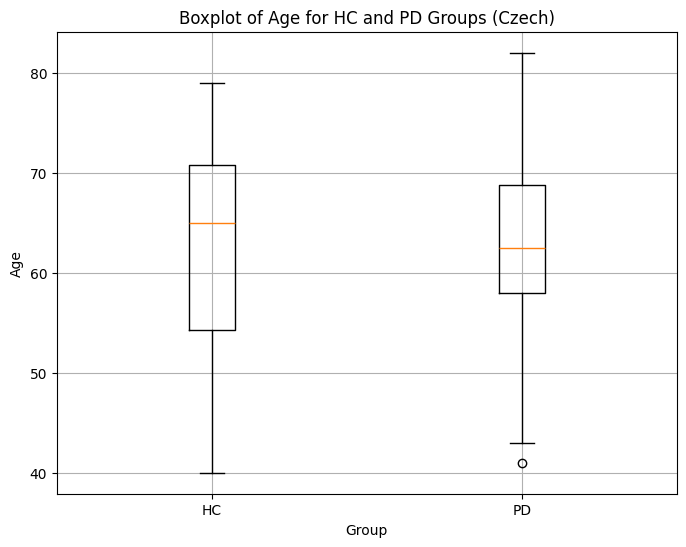

In [320]:
make_boxplot(cz_participants, 'Czech')

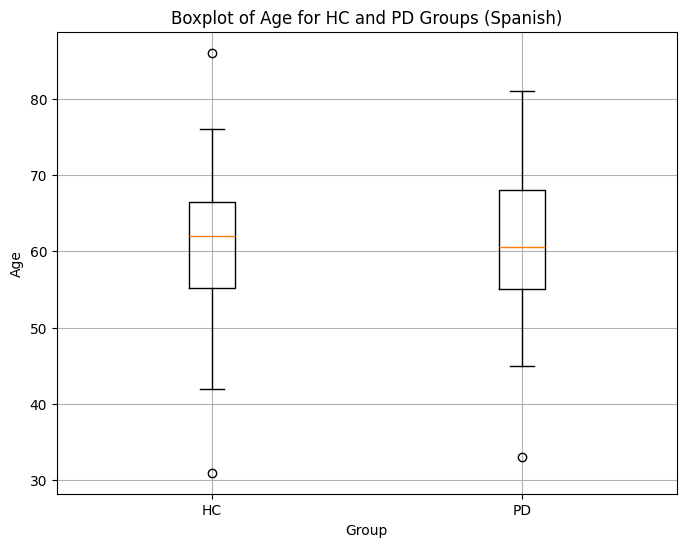

In [321]:
make_boxplot(sp_participants, 'Spanish')

In [322]:
cz_sex_frequency = calc_gender_frequency(cz_participants)
print(cz_sex_frequency)

status  sex
HC      M      30
        F      20
PD      M      30
        F      20
Name: sex, dtype: int64


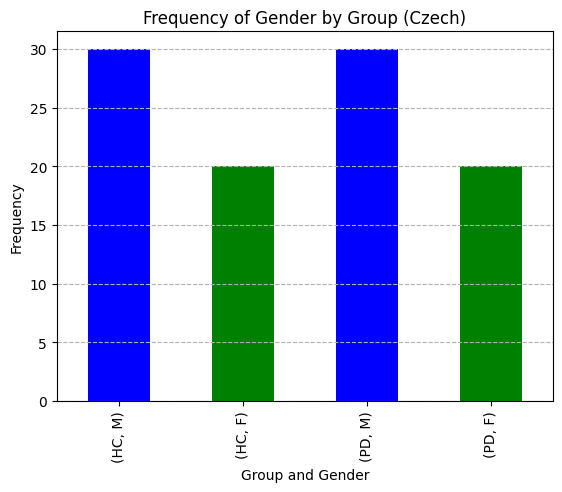

In [323]:
make_barchart(cz_sex_frequency, 'Czech')

In [324]:
sp_sex_frequency = calc_gender_frequency(sp_participants)
print(sp_sex_frequency)

status  sex
HC      F      25
        M      25
PD      F      25
        M      25
Name: sex, dtype: int64


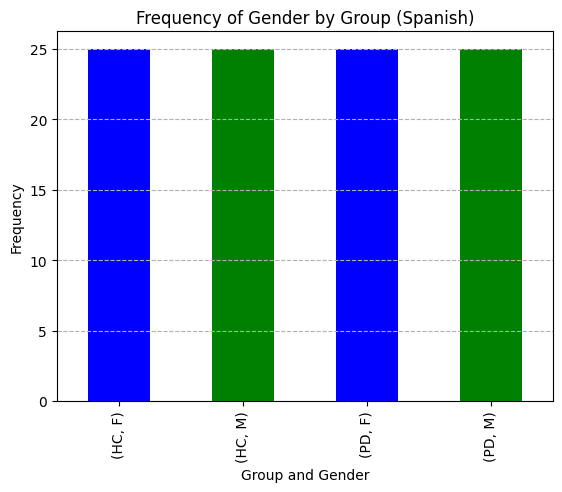

In [325]:
make_barchart(sp_sex_frequency, 'Spanish')

# Q3 Part 2 (Between)


In [346]:
#seperate healthy control from patients
cz_hc_participants = cz_participants[cz_participants['status'] == 'HC']
cz_pd_participants = cz_participants[cz_participants['status'] == 'PD']



sp_hc_participants = sp_participants[sp_participants['status'] == 'HC']
sp_pd_participants = sp_participants[sp_participants['status'] == 'PD']

In [347]:
sp_pd_participants 

,participant_id,age,sex,status
50,AVPEPUDEA0001,64,M,PD
51,AVPEPUDEA0002,72,F,PD
52,AVPEPUDEA0003,75,F,PD
53,AVPEPUDEA0005,65,M,PD
54,AVPEPUDEA0006,66,F,PD
55,AVPEPUDEA0007,55,F,PD
56,AVPEPUDEA0008,60,F,PD
57,AVPEPUDEA0009,57,F,PD
58,AVPEPUDEA0010,51,F,PD
59,AVPEPUDEA0011,55,F,PD


In [348]:

def calc_shapiro(column, alpha=0.05):
    """
    Perform the Shapiro-Wilk test to check for normal distribution of data.

    Parameters:
    - column (pandas.Series): A pandas Series containing the data to be tested for normality.
    - alpha (float, optional): The significance level for the test. Default is 0.05.

    Returns:
    - str: A message indicating whether the null hypothesis of normality is rejected or not.
    """
    test, p_value = shapiro(column)
        
    if p_value > alpha:
        return f"Given a p-value of {p_value}, we do not reject the null hypothesis. The data is normally distributed."
    else:
        return f"Given a p-value of {p_value}, we reject the null hypothesis. The data is not normally distributed."


In [349]:
print(calc_shapiro(cz_pd_participants['age']))

Given a p-value of 0.5056062936782837, we do not reject the null hypothesis. The data is normally distributed.


In [ ]:
def make_density_plot(dataset, language, group):
    """
    Create a kernel density estimation plot for the age distribution.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame containing participant data.
    - language (str): Language of the dataset used for the plot title.
    - group (str): Group name for which the density plot is generated.

    Returns:
    - None
    """
    sns.kdeplot(dataset['age'], shade=True)
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.title(f'Kernel Density Estimation of Age ({language} - {group})')
    plt.show()


In [ ]:
make_density_plot(cz_hc_participants, 'Czech', "HC")

In [ ]:
print(calc_shapiro(cz_pd_participants['age']))

In [ ]:
make_density_plot(cz_pd_participants, 'Czech', "PD")

In [ ]:
print(calc_shapiro(sp_hc_participants['age']))

In [ ]:
make_density_plot(sp_hc_participants, 'Spanish', "HC")

In [ ]:
print(calc_shapiro(sp_pd_participants['age']))

In [ ]:
make_density_plot(sp_pd_participants, 'Spanish', "PD")

In [ ]:
def calc_levene(dataset_a, dataset_b,column, centering_method, alpha= 0.05):
    """
    Perform Levene's test to compare the variability of ages between two groups.

    Parameters:
    - dataset_a (pandas.DataFrame): DataFrame containing data for group A.
    - dataset_b (pandas.DataFrame): DataFrame containing data for group B.
    - column (str): Name of the column containing age data.
    - centering_method (str or function): Method used to center the data for the test.
    - alpha (float, optional): The significance level for the test. Default is 0.05.

    Returns:
    - str: A message indicating whether the null hypothesis of equal variance is rejected or not.
    """
    w_stats, p_value = levene(dataset_a[column], dataset_b[column], center= centering_method)
    
    if p_value > alpha:
        return f"Given a p-value of {p_value} we do not reject the null hypothesis.There is no significant difference in the variability between the groups"
    else:
        return f"Given a p-value of {p_value} we reject the Null Hypothesis."


In [ ]:


# Perform Levene's test
statistic, p_value = calc_levene_age(cz_hc_participants['age'], sp_hc_participants['age'])

# Print the results
print("Levene's test statistic:", statistic)
print("p-value:", p_value)


In [ ]:
print(calc_levene_age(cz_pd_participants,sp_pd_participants,'age', 'mean'))



In [ ]:

cz_hc_participants['sex'].replace({'F': 0, 'M': 1}, inplace=True)


cz_pd_participants['sex'].replace({'F': 0, 'M': 1}, inplace=True)

sp_hc_participants['sex'].replace({'F': 0, 'M': 1}, inplace=True)

sp_pd_participants['sex'].replace({'F': 0, 'M': 1}, inplace=True)


In [ ]:
sp_hc_participants

In [ ]:
cz_hc_participants

In [ ]:
print(calc_levene(cz_hc_participants,sp_hc_participants, 'sex', 'median'))



In [ ]:
print(calc_levene(cz_pd_participants,sp_pd_participants, 'age', 'mean'))

# age differences

In [ ]:
cz_males_hc_age = cz_hc_participants[cz_hc_participants['sex'] == 1]['age']
cz_females_hc_age = cz_hc_participants[cz_hc_participants['sex'] == 0]['age']
cz_males_pd_age = cz_pd_participants[cz_pd_participants['sex'] == 1]['age']
cz_females_pd_age = cz_pd_participants[cz_pd_participants['sex'] == 0]['age']


In [ ]:
sp_males_hc_age = sp_hc_participants[sp_hc_participants['sex'] == 1]['age']
sp_females_hc_age = sp_hc_participants[sp_hc_participants['sex'] == 0]['age']
sp_males_pd_age = sp_pd_participants[sp_pd_participants['sex'] == 1]['age']
sp_females_pd_age = sp_pd_participants[sp_pd_participants['sex'] == 0]['age']

Perform Shapiro-Wilk tests to check for normality. The distribution of data is important because it determines the test we can use to assess the equality of variances.

In [ ]:
print(calc_shapiro(cz_males_hc_age))

In [ ]:
print(calc_shapiro(cz_females_hc_age))

In [ ]:
print(calc_shapiro(cz_males_pd_age))

In [ ]:
print(calc_shapiro(cz_females_pd_age))

In [ ]:
print(calc_shapiro(sp_males_hc_age))

In [ ]:
print(calc_shapiro(sp_females_hc_age))

In [ ]:
print(calc_shapiro(sp_males_pd_age)) 

In [ ]:
print(calc_shapiro(sp_females_pd_age)) 

Where data is normally distributed, we can use the Levene test to assess the equality of variances. However, since the age of Czech female participants in the control group is not normally distributed, in this case, we are going to use the Brown-Forsythe test. We can perform the Levene test by specifying 'mean' as the center parameter in the levene function and the Brown-Forsythe test by specifying 'median' as the center parameter.

In [ ]:
cz_levene_hc = levene(cz_males_hc_age, cz_females_hc_age, center = 'median')
print(cz_levene_hc[1])

In [ ]:
cz_levene_pd = levene(cz_males_pd_age, cz_females_pd_age, center = 'mean')
print(cz_levene_pd[1])

In [ ]:
sp_levene_hc = levene(sp_males_hc_age, sp_females_hc_age, center = 'mean')
print(sp_levene_hc[1])

In [ ]:
sp_levene_pd = levene(sp_males_pd_age, sp_females_pd_age, center = 'mean')
print(sp_levene_pd[1])